In [42]:
import pandas as pd
import numpy as np
import os
import datetime
import seaborn as sns

In [4]:
# Load the dataset
df_o = pd.read_csv('./data/USvideos.csv')
df = df_o.copy()

### Dataset Description ###  
This dataset contains stats on U.S. based videos posted on YouTube. There are 40,949 records - each representing a video post. Each video post in the dataset contains 16 features, including: views, likes, dislikes, comment count, title, description, tags, publish date, trending date, etc. 

In [5]:
print(df.describe().astype('int'))

       category_id      views    likes  dislikes  comment_count
count        40949      40949    40949     40949          40949
mean            19    2360784    74266      3711           8446
std              7    7394113   228885     29029          37430
min              1        549        0         0              0
25%             17     242329     5424       202            614
50%             24     681861    18091       631           1856
75%             25    1823157    55417      1938           5755
max             43  225211923  5613827   1674420        1361580


### Variable Description

**1. Category ID:** The category of the video.  
**2. Views:** On average, the videos in this dataset received 2,360,784 views. The median received 681,861; while the max received 225,211,923. The outliers are driving the average higher.   
**3. Likes:** Likes variable share similar charecteristics as views.  
**4. Dislikes:** Dislikes variable share similar charecteristics as views.    
**5. Comment Count:** Comments variable share similar charecteristics as views.    

In [6]:
# What are the column types?
# Descriptive stats of Comment Count, Likes and Dislikes are skewed as some videos have comments and/or reviews disabled. 
print(df.dtypes.sort_values())

comments_disabled           bool
ratings_disabled            bool
video_error_or_removed      bool
category_id                int64
views                      int64
likes                      int64
dislikes                   int64
comment_count              int64
video_id                  object
trending_date             object
title                     object
channel_title             object
publish_time              object
tags                      object
thumbnail_link            object
description               object
dtype: object


### Variables Summary ###
Dataset seems to have large outliers that are driving these numbers out of wack.  
  
Descriptive stats for Comment Count, Likes and Dislikes are skewed as some videos have comments and/or reviews disabled.  
Normalizing the stats by eliminating those videos that have disabled ratings and comments might make the dataset more useful.

### What's the goal? ###  
**VIEWS** is the currency of YouTubers. The more views one gets, the more subscribers, followers and money they make. Our goal is to ask questions in relation to views.  

While the variables that the dataset provided seems useful, I'd like to know the video length to do analysis on views. I suspect that shorter videos receive more views, reiviews and/or comments. If that is the case, then when we post videos on YT, our video length should be within that range that experiences more views.
  
In order to answer this question, we must reach out to YouTube - either by scraping the length of each video or accessing the YT API to get this data.  
  
Additionally, once we normalize the data and retrieve all the additional variables through scraping and feature engineering, we'll run a regression analysis to better understand the relationship and impact of the variables on video views.  

### Feature Engineering Plan/Questions ###  
**Tags:** How many tags does each video have? Does the more tags a video have garner more views, given its more discoverable? Does having an overwhelming amount of tag hurt you?  
  
**Description:** Does the length of the description help or hurt views?  
  
**Title:** Does the length of the title play a role in receiving more views? Do similar titles cannabalize views?  
  
**Channel Title:** Are there similar sounding channels? Maybe too many similar sounding channels cannabalize each others views?

**Publish and Trending Date:** On average, how long does it take for a video to go treding? What are the characteristics of the videos with the long lead time vs those with short lead time?  

### Tags ###
Tags look like they are seperated by the pipe symbol. Each tag after the first tag has quotes which should be scrubed.  
We'll create a column to seperate and count each tag, as well as count duplicate tags.

In [7]:
df['tags'][10:20]

10    NFL|"Football"|"offense"|"defense"|"afc"|"nfc"...
11    The Walking Dead|"shiva"|"tiger"|"king ezekiel...
12    marshmello|"blocks"|"marshmello blocks"|"block...
13    nowthis|"nowthis world"|"world news"|"nowthis ...
14    shopping for new fish|"new fish"|"aquarium fis...
15    Robots|"Boston Dynamics"|"SpotMini"|"Legged Lo...
16    pacific rim|"pacific rim 2"|"pacific rim seque...
17    TED|"TED-Ed"|"TED Education"|"TED Ed"|"Hilary ...
18    ultralight|"airplane"|"homemade"|"DIY"|"hoverb...
19    SciShow|"science"|"Hank"|"Green"|"education"|"...
Name: tags, dtype: object

In [8]:
# One time functions
cleanTags = lambda x: x.lower().replace('"','').split('|')
checkDups = lambda x: {i:cleanTags(x).count(i) for i in cleanTags(x)}

In [9]:
# Generate additional tag fields
df['tags_clean'] = df['tags'].apply(cleanTags)
df['tags_count_use'] = df['tags'].apply(cleanTags).apply(len)
df['tags_dups'] = df['tags'].apply(checkDups)
df['tags_dups_count_use'] = df['tags_dups'].apply(dict.values).apply(max)

### Description ###  
Very unscrutured. The only thing we can get from here is the length of the string.  
  
For additional analysis, we should see if the tags are present in the description. This will help us answer the question: are tags an addition to the description or should they contain duplicate terms.

In [10]:
df['description_count_use'] = df['description'].apply(str).apply(lambda x: len(x))

### Title ###  
Similar to Description, we should get the length of the title.  
  
For additional analysis, we should see if the tags are present in the title. If so, what position in the title does the tag take: beginning, middle, end? This will help us answer the question: are tags an addition to the title or should they contain duplicate terms. Also, this analysis could help us understand the importance of tags - do the search algorithm prioritize search results based on tag relevancy to the title?

In [11]:
df['tile_count_use'] = df['title'].apply(str).apply(lambda x: len(x))

### Publish and Trending Date ###  
Both variables need to be normalized as they are both in different formats.  
We will get the difference between trending and publish date. This will give us insight into, on average, how long do we have to wait for our video to go trending? Additionally, what is the relationship between trending lead time and the length of the video? Do shorter videos trend faster?  
  
Additionally, we will tease out the time it was published. For videos that trend on the same date it was published, the time it was published might give us an insight into when we should release our video to the public. I assume that prime time is the best time to publish.

In [12]:
df[['publish_time', 'trending_date']][10:20]

,publish_time,trending_date
10,2017-11-13T02:05:26.000Z,17.14.11
11,2017-11-13T03:00:00.000Z,17.14.11
12,2017-11-13T17:00:00.000Z,17.14.11
13,2017-11-12T14:00:00.000Z,17.14.11
14,2017-11-12T18:30:01.000Z,17.14.11
15,2017-11-13T20:09:58.000Z,17.14.11
16,2017-11-12T17:00:05.000Z,17.14.11
17,2017-11-13T16:00:07.000Z,17.14.11
18,2017-11-13T15:30:17.000Z,17.14.11
19,2017-11-12T22:00:01.000Z,17.14.11


**Create singleton, lambda functions**

In [13]:
getTime = lambda x: str(datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.000Z').time())
getDate = lambda x: datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.000Z').date()
getDateFormatted = lambda x: getDate(datetime.datetime(int(x[0:2]), int(x[6:8]), int(x[3:5])).strftime('20%Y-%m-%dT%H:%M:%S.000Z'))
getDateDifference = lambda x: x.days

**Apply functions to Dataset to create new variables**

In [14]:
df['publish_time_date'] = df['publish_time'].apply(getDate)
df['publish_time_time_use'] = df['publish_time'].apply(getTime)
df['trending_date_date'] = df['trending_date'].apply(getDateFormatted)
df['trend_lead_use'] = (df['trending_date_date'] - df['publish_time_date']).apply(getDateDifference)

### Review New Variables ###
Off the bat, looking at the new variables, we can clearly see that the duplicate tags calculation we generate gives us no data: almost all video posts do not have duplicate tags. We will not be using this variable.  
  
Additionally, some outlier analysis must be done to the trend lead variable as 75% of the video posts in this dataset had at least a 9 day trend lead. However, there are some or one exception: a max of 4,215 trend lead. We should look into this/these video post(s) and discard or fix the result to be able to use this variable efficiently.

The rest of the other variables look decent enough to continuie working with.

In [15]:
print(df.describe().astype('int'))

       category_id      views    likes  dislikes  comment_count  \
count        40949      40949    40949     40949          40949   
mean            19    2360784    74266      3711           8446   
std              7    7394113   228885     29029          37430   
min              1        549        0         0              0   
25%             17     242329     5424       202            614   
50%             24     681861    18091       631           1856   
75%             25    1823157    55417      1938           5755   
max             43  225211923  5613827   1674420        1361580   

       tags_count_use  tags_dups_count_use  description_count_use  \
count           40949                40949                  40949   
mean               19                    1                   1031   
std                12                    0                    854   
min                 1                    1                      1   
25%                10                    1         

### Features for Analysis ###

In [18]:
features = ['views', 'likes', 'dislikes', 'comment_count', 'tags_count_use', 'description_count_use','tile_count_use', 'trend_lead_use']
df_use = df[features]

### Quick Visuals to Measure Relationships ###  
The strongest correlation we can glean exists between the original variables. Correlation between the original variables and new variables seem to be non existent.

In [34]:
def getCorrHeatmap():
    corr = df_use.corr()
    ax = sns.heatmap(
        corr, 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    );

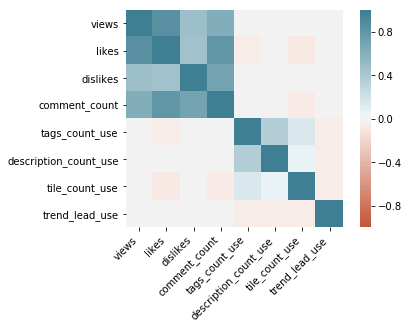

In [36]:
getCorrHeatmap()

**Deeper Dive into Relationships**

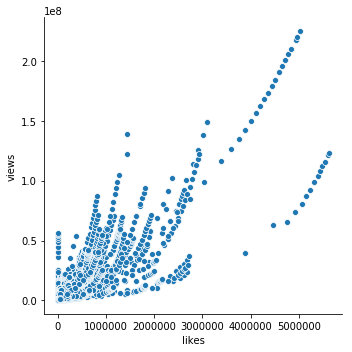

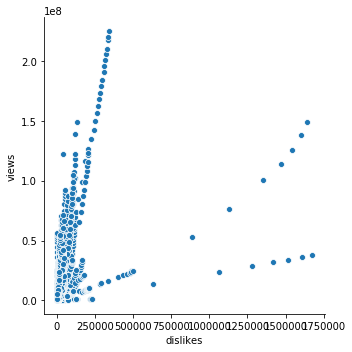

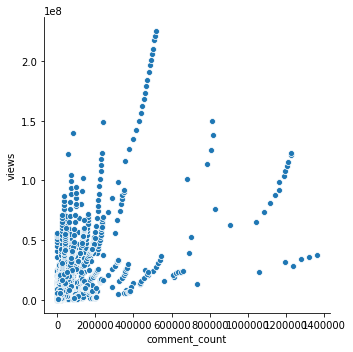

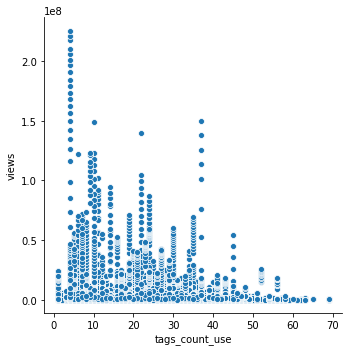

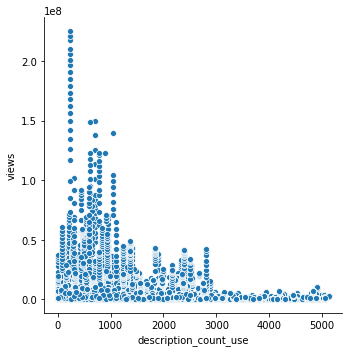

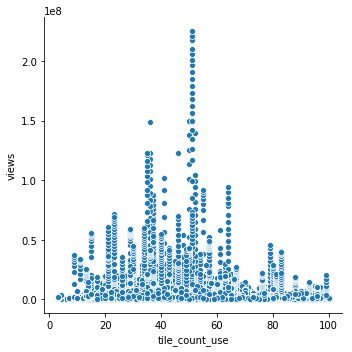

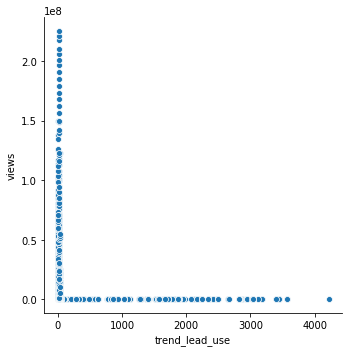

In [39]:
for i in features:
    if(i != 'views'):
        sns.relplot(x=i, y="views", data=df_use);

In [45]:
df_use['views_log'] = df_use['views'].apply(np.log10)

/home/christianbm/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


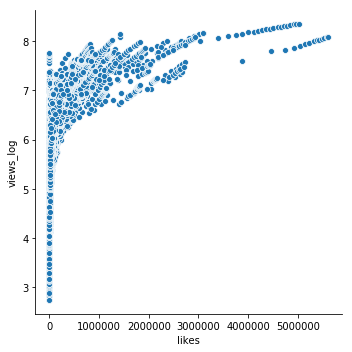

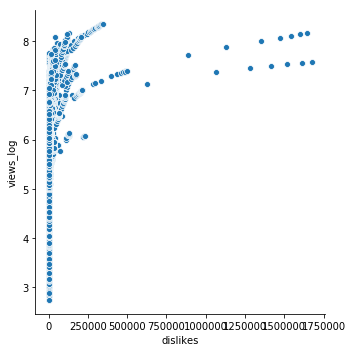

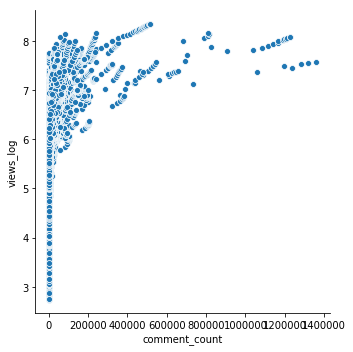

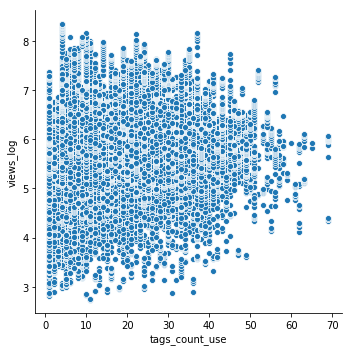

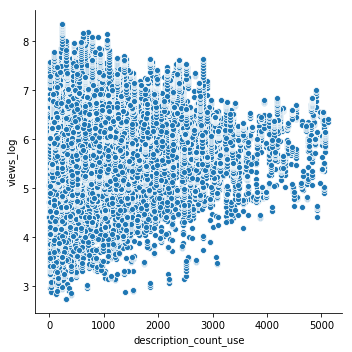

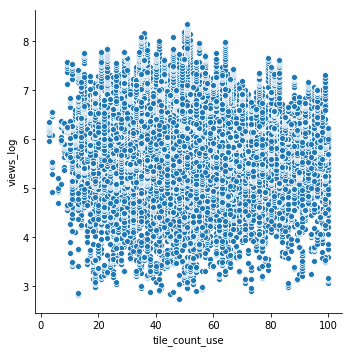

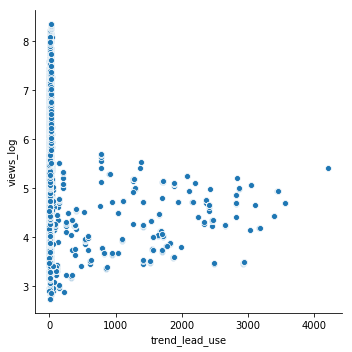

In [48]:
for i in features:
    if(i != 'views' and i != 'views_log'):
        sns.relplot(x=i, y="views_log", data=df_use);

**Views Feature**  
As mentioned above, the Views feature is out of wack given the large outliers. In order to go into a deeper analysis, I'll have to do some outlier analysis - whether fixing the values or discarding.

/home/christianbm/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


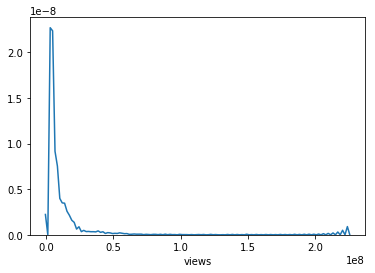

In [52]:
sns.distplot(df_use['views'], hist=False)